## Quick Note

I'm trying something new! This blog post is available in two places, both here and [on my actual blog](https://freethoughtblogs.com/reprobate/). Over here, you can tweak and execute my source code, using it as a sandbox for your own explorations. Over there, it's just a boring ol' webpage without any fancy features, albeit one that's easier to read on the go. Choose your own adventure!

Oh also, **CONTENT WARNING**: I'll briefly be discussing sexual assault statistics from the USA at the start, in an abstract sense.

# Introduction

> \[[5:08](https://youtu.be/02FCYz8bOo8?t=308)\] Now this might seem pedantic to those not interested in athletics, but in the athletic world one percent is absolutely massive. Just take for example the 2016 Olympics. The difference between first and second place in the men's 100-meter sprint was 0.8%.

I've covered [this argument from Rationality Rules](https://freethoughtblogs.com/reprobate/2019/05/30/rationality-rules-is-an-oblivious-transphobe/) before, but time has made me realise my original presentation had a problem.

His name is Steven Pinker.

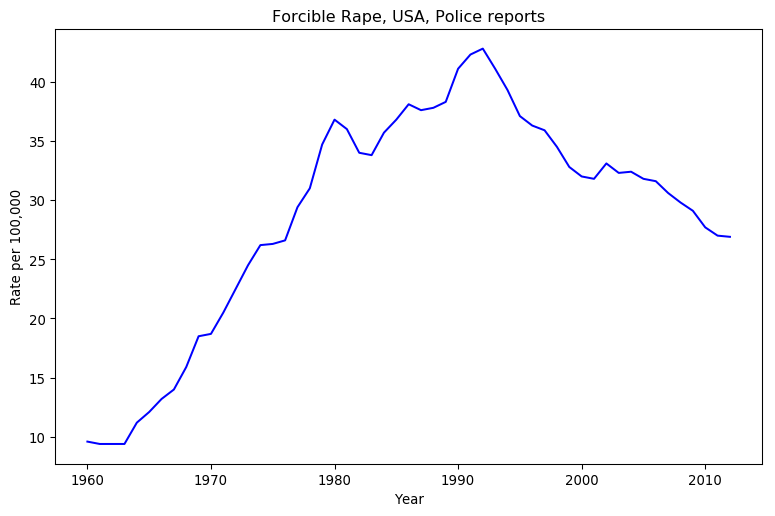

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

assault = pd.read_csv('data/pinker_rape_usa.tsv',sep='\t')

plt.rcParams['figure.dpi'] = 96
plt.rcParams['figure.figsize'] = [9.5, 6]

plt.plot( assault['# Year'], assault['Rate'], 'b' )
plt.title('Forcible Rape, USA, Police reports')
plt.xlabel('Year')
plt.ylabel('Rate per 100,000')
plt.show()

He looks at that graph, and sees a decline in violence. [I look at that chart](https://freethoughtblogs.com/reprobate/2016/08/28/steven-pinker-and-his-portable-goalposts/), and see an increase in violence. How can two people look at the same data, and come to contradictory conclusions?

Simple, we've got at least two separate mental models.

Finding the maximal likelihood, please wait ... done.
Running an MCMC sampler, please wait ... done.
Charting the results, please wait ...


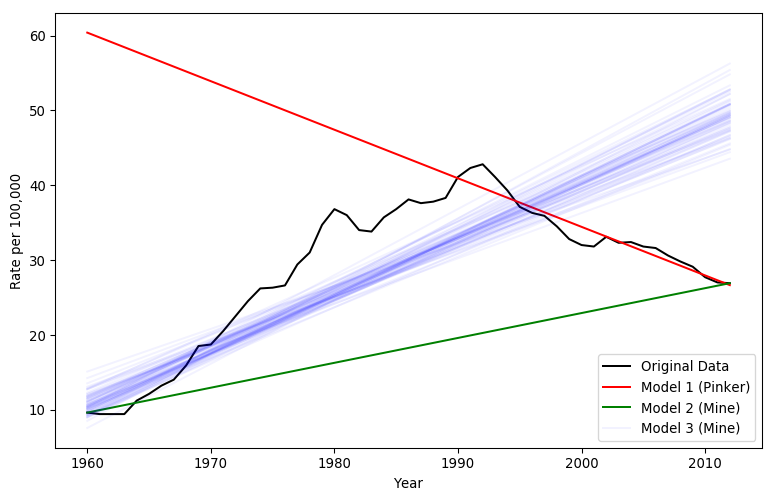

In [15]:
import emcee
import numpy as np
import os
import scipy.optimize as spop

# Some of this code is based on the following examples:
#  https://emcee.readthedocs.io/en/v2.2.1/user/line/
#  https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/

def lnLinear( theta, x, y ):
    intercept, slope, lnStdDev = theta
    prior       = -1.5*np.log1p(slope*slope) - lnStdDev
    model       = slope*x + intercept        
    inv_sig2    = 1. / (model**2 * np.exp(2*lnStdDev))
    return prior - .5*( np.sum( ((y-model)**2) * inv_sig2 - np.log(inv_sig2) ) )

# Model 1: What's happened over the last two decades?
negLnLin = lambda *args: -lnLinear(*args)

max_year = np.max( assault['# Year'] )
start = 1991
end = max_year

mask = assault['# Year'] > start
print("Finding the maximal likelihood, please wait ...", end='')
intercept_1, slope_1, error_1 = spop.minimize( negLnLin, [1000,-1,5], 
        args=(assault['# Year'][mask], assault['Rate'][mask]) )['x']
print(" done.")

# Model 2: Where are the extremes?
min_year = np.min( assault['# Year'] )
slope_2 = (float(assault['Rate'][assault['# Year']==max_year]) - float(assault['Rate'][assault['# Year']==min_year])) / \
    (max_year - min_year)
intercept_2 = float(assault['Rate'][assault['# Year']==min_year] - slope_2*min_year)

# Model 3: What trendlines fit the data?
ndim, nwalkers, nsamples, keep = 3, 64, 300, 1
seed = [np.array([intercept_2,slope_2,3.]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnLinear, threads=os.cpu_count(),
        args=[ np.array(assault['# Year']), np.array(assault['Rate']) ] )
print("Running an MCMC sampler, please wait ...", end='')
sampler.run_mcmc(seed, nsamples)
print(" done.")

model_3 = sampler.chain[:, -keep:, :].reshape((-1, ndim))

print("Charting the results, please wait ...")
plt.plot( assault['# Year'], assault['Rate'], 'k' )
plt.xlabel('Year')
plt.ylabel('Rate per 100,000')
plt.plot( assault['# Year'], slope_1*assault['# Year'] + intercept_1, 'r' )
plt.plot( assault['# Year'], slope_2*assault['# Year'] + intercept_2, 'g' )
for entry in model_3:
    plt.plot( assault['# Year'], entry[1]*assault['# Year'] + entry[0], 'b', alpha=0.05 )
plt.legend( ['Original Data', 'Model 1 (Pinker)', 'Model 2 (Mine)', 'Model 3 (Mine)'])
plt.show()

All Pinker cares about is short-term trends here, as he's focused on "The Great Decline" in crime since the 1990's. His mental model looks at the general trend over the last two decades of data, and discards the rest of the datapoints. It's the model I've put in red.

I used two seperate models in [my blog post](https://freethoughtblogs.com/reprobate/2016/08/28/steven-pinker-and-his-portable-goalposts/). The first is quite crude: is the last datapoint better than the first? This model is quite intuitive, as it amounts to "leave the place in better shape than when you arrived," and it's dead easy to calculate. It discards all but two datapoints, though, which is worse than Pinker's model. I've put this one in green.

The best model, in my opinion, wouldn't discard any datapoints. It would also incorporate as much uncertainty as possible about the system. Unsurprisingly, given my [blogging](https://freethoughtblogs.com/reprobate/2015/12/17/index-post-p-values/) [history](https://sinmantyx.wordpress.com/2015/04/04/bayes-theorem-201-odds-ratios-bayes-factors-and-cute-animals/), I consider Bayesian statistics to be the best way to represent uncertainty. A linear model is the best choice for general trends, so I went with a three-parameter likelihood and prior:

$$ p( x,y | m,b,\log(\sigma) ) = e^{ -\frac 1 2 \big(\frac{y-k}{\sigma}\big)^2 }(\sigma \sqrt{2\pi})^{-1}, ~ k = x \cdot m + b $$
$$ p( m,b,\log(\sigma) ) = \frac 1 \sigma (1 + m^2)^{-\frac 3 2} $$

This third model encompasses all possible trendlines you could draw on the graph, but it doesn't hold them all to be equally likely. Since time is short, I used [an MCMC sampler](https://emcee.readthedocs.io/en/v2.2.1/) to randomly sample the resulting probability distribution, and charted that sample in blue. As you can imagine this requires a **lot** more calculation than the second model, but I can't think of anything superior.

Which model is best depends on the context. If you were arguing just over the rate of police-reported sexual assault from 1992 to 2012, Pinker's model would be pretty good [if incomplete](https://www.thenation.com/article/how-did-fbi-miss-over-1-million-rapes/). However, his whole schtick is that [long-term trends show a decrease in violence](https://www.penguinrandomhouse.com/books/317051/enlightenment-now-by-steven-pinker/9780143111382/), and when it comes to sexual violence in particular [he's the only one who dares to talk about this](https://freethoughtblogs.com/pharyngula/2019/07/12/pinker-speaks-up-at-last-about-epstein/#comment-2003065). He's not being self-consistent, which is easier to see when you make your implicit mental models explicit.

## Pointing at Variance Isn't Enough

Let's return to Rationality Rules' [latest transphobic video](https://www.youtube.com/watch?v=02FCYz8bOo8). In [the citations](https://docs.google.com/document/d/1SM8zbftYHzy8r2VrOpGtWxPxC2QrEvUvXmmBJixpKy8/edit), he explicitly references the [men's 100m sprint](https://www.olympic.org/rio-2016/athletics/100m-men) at the 2016 Olympics. That's a terribly narrow window to view athletic performance through, so I tracked down the racetimes of all eight finalists on [the IAAF's website](https://www.iaaf.org/athletes/jamaica/usain-bolt-184599) and tossed them into [a spreadsheet](data/100_metre.tsv).

In [3]:
dataset = pd.read_csv('data/100_metre.tsv',delimiter='\t',parse_dates=[1],dayfirst=True,dtype={'Result':np.float64,'Wind':np.float64})

olympics_2016 = dataset['Competition'] == "Rio de Janeiro Olympic Games"
finals = dataset['Race'] == "F"

fastest_time = min(dataset['Result'][olympics_2016 & finals])

table = {"Athlete":dataset['# Name'][olympics_2016 & finals],
         "Result":dataset['Result'][olympics_2016 & finals],
         "Delta":dataset['Result'][olympics_2016 & finals] - fastest_time
        }
print("Rio de Janeiro Olympic Games, finals")
print( pd.DataFrame(table).sort_values("Result").to_string(index=False) )

Rio de Janeiro Olympic Games, finals
Athlete  Result  Delta
     bolt    9.81   0.00
   gatlin    9.89   0.08
de grasse    9.91   0.10
    blake    9.93   0.12
  simbine    9.94   0.13
    meite    9.96   0.15
   vicaut   10.04   0.23
  bromell   10.06   0.25


Here, we see exactly what Rationality Rules sees: [Usain Bolt](https://www.iaaf.org/athletes/jamaica/usain-bolt-184599), the current world record holder, earned himself another Olympic gold medal in the 100m sprint. First and third place are separated by a tenth of a second, and the slowest person in the finals was a mere quarter of a second behind the fastest. That's a small fraction of the time it takes to complete the event.

In [4]:
mask_2016   = (dataset['Date'] > '2016-01-01') & (dataset['Date'] < '2017-01-01')
names_2016  = pd.Categorical( dataset['# Name'] ).categories

all_2016    = list()
for name in names_2016:
    temp = np.array( dataset['Result'][mask_2016 & (dataset['# Name'] == name)] )
    temp.sort()
    all_2016.append( temp )

all_career = list()
for name in names_2016:
    all_career.append( np.max( dataset['Date'][dataset['# Name'] == name] ) - np.min( dataset['Date'][dataset['# Name'] == name] ) )

all_races = list()
for name in names_2016:
    all_races.append( len( dataset['Result'][dataset['# Name'] == name] ) )

mean_time       = sorted( np.linspace(0,len(all_2016)-1,len(all_2016),dtype=int), key=lambda x:np.mean(all_2016[x]))
median_time     = sorted( np.linspace(0,len(all_2016)-1,len(all_2016),dtype=int), key=lambda x:np.median(all_2016[x]))
min_time        = sorted( np.linspace(0,len(all_2016)-1,len(all_2016),dtype=int), key=lambda x:np.min(all_2016[x]))
fastest_time    = np.min([ np.min(data) for data in all_2016 ])

print('Race times in 2016, sorted by fastest time')
print("{0:16} {1:16} {2:16} {3:16} {4:16}".format('Name','Min time', 'Mean', 'Median', 'Personal max-min'))
print("{}".format( '-' * (6*16 + 5) ))
for i in min_time:
    print("{0:16} {1:16} {2:12.2f} {3:12.2f} {4:12.2f}".format( names_2016[i], np.min(all_2016[i]), np.mean(all_2016[i]), 
        np.median(all_2016[i]), np.max(all_2016[i]) - np.min(all_2016[i]) ))


Race times in 2016, sorted by fastest time
Name             Min time         Mean             Median           Personal max-min
-----------------------------------------------------------------------------------------------------
gatlin                        9.8         9.95         9.94         0.39
bolt                         9.81         9.98        10.01         0.34
bromell                      9.84        10.00        10.01         0.30
vicaut                       9.86        10.01        10.02         0.33
simbine                      9.89        10.10        10.08         0.43
de grasse                    9.91        10.07        10.04         0.41
blake                        9.93        10.04         9.98         0.33
meite                        9.95        10.10        10.05         0.44


Here, we see what I see: the person who won Olympic gold that year *didn't have the fastest time*. That honour goes to [Justin Gatlin](https://www.iaaf.org/athletes/united-states/justin-gatlin-176453), who squeaked ahead of Bolt by a hundredth of a second. 

Come to think of it, isn't the fastest time a poor judge of how good an athlete is? Picture one sprinter with a faster average time than another, and a second with a faster minimum time. The first athlete will win more races than the second. By that metric, Gatlin's lead grows to three hundredths of a second.

The mean, alas, is easily tugged around by outliers. If someone had an exceptionally good or bad race, they could easily shift their overall mean a decent ways from where the mean of every other result lies. The [median](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/mean-median-basics/a/mean-median-and-mode-review) is a lot more resistant to the extremes, and thus a fairer measure of overall performance. By that metric, Bolt is now tied for *third* with [Trayvon Bromell](https://www.iaaf.org/athletes/united-states/trayvon-bromell-273179).

We could also judge how good an athlete is by how consistent they were in the given calendar year. By this metric, Bolt falls into fourth place behind Bromell, [Jimmy Vicaut](https://www.iaaf.org/athletes/france/jimmy-vicaut-248925), and [Yohan Blake](https://www.iaaf.org/athletes/jamaica/yohan-blake-208640). Even if you don't agree to this metric, notice how everyone's race times in 2016 varies between three and four tenths of a second. It's hard to argue that a performance edge of a tenth of a second matters when even at the elite level sprinters' times will vary by significantly more.

But let's put on our Steven Pinker glasses. We don't judge races by medians, we go by the fastest time. We don't award records for the lowest average or most consistent performance, we go by the fastest time. Yes, Bolt didn't have the fastest 100m time in 2016, but now we're down to hundredths of a second; if anything, we've dug up *more* evidence that itty-bitty performance differences matter. If I'd just left things at that last paragraph, which is about as far as I progressed the argument [last time](https://freethoughtblogs.com/reprobate/2019/05/30/rationality-rules-is-an-oblivious-transphobe/), a Steven Pinker would likely have walked away even more convinced that Rationality Rules got it right.

I don't *have* to leave things there, though. This time around, I'll make my mental model as explicit as possible. Hopefully by fully arguing the case, instead of dumping out data and hoping you and I share the same mental model, I could manage to sway even a diehard skeptic. To further seal the deal, the Jupyter notebook will allow you to audit my thinking or even create your own model. No need to take my word.

I'm laying everything out in clear sight. I hope you'll give it all a look before dismissing me.

# The Model

Our choice of model will be guided by the assumptions we make about how athletes perform in the 100 metre sprint. If we're going to do this properly, we have to lay out those assumptions as clearly as possible.

1. **The Best Athlete Is the One Who Wins the Most**. Our first problem is to decide what we mean by "best," when it comes to the 100 metre sprint. Rather than use any metric like the lowest possible time or the best overall performance, I'm going to settle on something I think we'll both agree to: the athlete who wins the most races is the best. We'll be pitting our models against each other as many times as possible via virtual races, and see who comes out on top.

2. **Pobody's Nerfect**. There is always going to be a spanner in the works. Maybe one athlete has a touch of the flu, maybe another is going through a bad breakup, maybe a third got a rock in their shoe. Even if we can control for all that, human beings are complex machines with many moving parts. Our performance will vary. This means we can't use point estimates for our model, like the minimum or median race time, and instead must use a [continuous statistical distribution](https://en.wikipedia.org/wiki/Probability_distribution#Continuous_probability_distribution).

 This assumption might seem like begging the question, as variance is central to my counter-argument, but note that I'm only asserting there's some variance. I'm not saying *how much* variance there is. It could easily be so small as to be inconsequential, in the process creating strong evidence that Rationality Rules was right.
 
3. **Physics Always Wins**. No human being can run at the speed of light. For that matter, nobody is going to break the sound barrier during the 100 metre sprint. This assumption places a hard constraint on our model, that there is a minimum time *anyone* could run the 100m. It rules out a number of potential candidates, like the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution), which allow negative times.

4. **It's Easier To Move Slow Than To Move Fast**. This is kind of related to the last one, but it's worth stating explicitly. Kinetic energy is proportional to the square of the velocity, so building up speed requires dumping an ever-increasing amount of energy into the system. Thus our model should have a bias towards slower times, giving it a lopsided look.

Based on all the above, I propose the [Gamma distribution](http://mathworld.wolfram.com/GammaDistribution.html) would make a suitable model.

$$ \Gamma(x | \alpha, \beta ) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x} $$

(Be careful not to confuse the distribution with [the function](http://mathworld.wolfram.com/GammaFunction.html). I may need the Gamma function to calculate the Gamma distribution, but the Gamma function isn't a valid probability distribution.)

Three versions of the Gamma Distribution


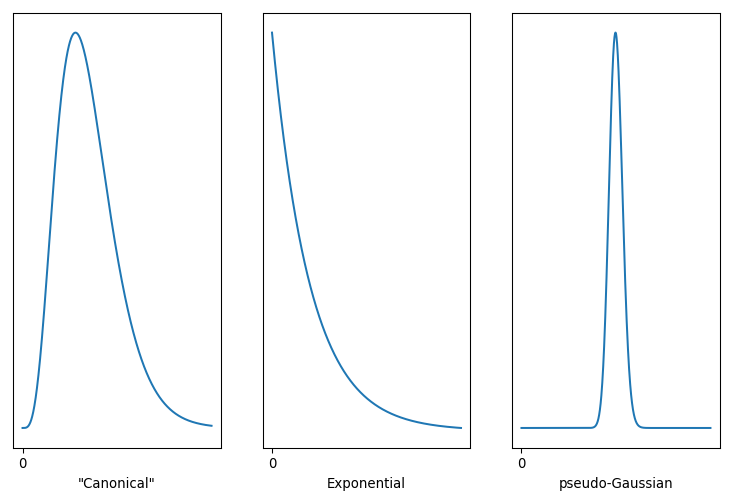

In [17]:
import scipy.stats as spst

x = np.linspace(0,10,1023)

print("Three versions of the Gamma Distribution")

plt.subplot( 131 )
plt.plot( x, spst.gamma.pdf(x, 5, scale=.7) )
plt.xticks([0])
plt.yticks([])
plt.xlabel('"Canonical"')

plt.subplot( 132 )
plt.plot( x, spst.gamma.pdf(x, 1, scale=2) )
plt.xticks([0])
plt.yticks([])
plt.xlabel('Exponential')

plt.subplot( 133 )
plt.plot( x, spst.gamma.pdf(x, 200, scale=.025) )
plt.xticks([0])
plt.yticks([])
plt.xlabel('pseudo-Gaussian')

plt.show()

It's a remarkably flexible distribution, capable of duplicating both the [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution) and Gaussian distributions. That's handy, as if one of our above assumptions is wrong the fitting process could still come up with a good fit. Note that the Gamma distribution has a finite bound at zero, which is equivalent to stating that negative values are impossible. The variance can be expanded or contracted arbitrarily, so it isn't implicitly supporting my arguments. Best of all, we're not restricted to anchor the distribution at zero. With a little tweak ...

$$ \Gamma(x | \alpha, \beta, b ) = \frac{\beta^\alpha}{\Gamma(\alpha)} \hat x^{\alpha-1} e^{-\beta \hat x}, ~ \hat x = x - b $$

... we can shift that zero mark wherever we wish. The $b$ parameter sets the minimum value our model predicts, while $\alpha$ controls the underlying shape and $\beta$ controls the scale or rate associated with this distribution. $\alpha < 1$ nets you the Exponential, and large values of $\alpha$ lead to something very Gaussian. Conveniently for me, SciPy [already supports](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma) this three-parameter tweak.

My intuition is that the Gamma distribution on the left, with $\alpha > 1$ but not too big, is the best model for athlete performance. That implies an athlete's performance will hover around a specific value, and while they're capable of faster times those are more difficult to pull off. The Exponential distribution, with $\alpha < 1$, is most favourable to Rationality Rules, as it asserts the race time we're most likely to observe is also the fastest time an athlete can do. We'll never actually see that time, but what we observe will cluster around that minimum.

## Running the Numbers

Enough chatter, let's fit some models! For this one, my prior will be

$$ p( \alpha, \beta, b ) = \begin{cases}
 0, & \alpha \le 0 \\
 0, & \beta \le 0 \\
 0, & b \le 0 \\
 1, & \text{otherwise}
\end{cases},$$

which is pretty light and only exists to filter out garbage values.

In [18]:
import sys

def lnprob( theta, data ):

    alpha, beta, b   = theta
    if (alpha <= 0) or (beta <= 0) or (b <= 0):
        return -np.inf
    return np.sum( spst.gamma.logpdf( data, alpha, scale=beta, loc=b ) )

ndim, nwalkers, nsamples, keep = 3, 64, 300, 5
models = [[] for x in all_2016]
summaries = [[] for x in all_2016]

print("Generating some models for 2016 race times (a few seconds each) ...")
print( "{:16}\t{:16}\t{:16}\t{:16}".format("# name","α","β","b") )
for loc,idx in enumerate(min_time):

    data = all_2016[idx]

    mean = np.mean( data ) - fastest_time      # adjust for the location offset
    seed = list()
    i = 0
    while i < nwalkers:
        beta = np.random.rand()*1.5 + .5
        b = fastest_time - np.random.rand()*.3

        if lnprob( [mean*beta, beta, b], data ) > -np.inf:
            seed.append( [mean*beta, beta, b] )
            i += 1

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], threads=os.cpu_count())
    sampler.run_mcmc(seed, nsamples)

    samples = sampler.chain[:, -keep:, :].reshape((-1, ndim))
    alpha_mcmc, beta_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
        zip(*np.percentile(samples, [16, 50, 84], axis=0)))

    print("{:16}".format(names_2016[idx]), end='')
    print("\t{:.3f} (+{:.3f} -{:.3f})".format(*alpha_mcmc), end='')
    print("\t{:.3f} (+{:.3f} -{:.3f})".format(*beta_mcmc), end='')
    print("\t{:.3f} (+{:.3f} -{:.3f})".format(*b_mcmc))
    sys.stdout.flush()

    models[idx] = samples
    summaries[idx] = [*alpha_mcmc, *beta_mcmc, *b_mcmc]

print("... done.")

Generating some models for 2016 race times (a few seconds each) ...
# name          	α               	β               	b               
gatlin          	0.288 (+0.112 -0.075)	1.973 (+0.765 -0.511)	9.798 (+0.002 -0.016)
bolt            	0.310 (+0.107 -0.083)	1.723 (+0.596 -0.459)	9.802 (+0.008 -0.025)
bromell         	0.339 (+0.115 -0.082)	1.677 (+0.570 -0.404)	9.836 (+0.004 -0.032)
vicaut          	0.332 (+0.066 -0.084)	1.576 (+0.315 -0.400)	9.856 (+0.004 -0.013)
simbine         	0.401 (+0.077 -0.068)	1.327 (+0.256 -0.226)	9.887 (+0.003 -0.018)
de grasse       	0.357 (+0.073 -0.082)	1.340 (+0.274 -0.307)	9.907 (+0.003 -0.022)
blake           	0.289 (+0.103 -0.085)	1.223 (+0.437 -0.361)	9.929 (+0.001 -0.008)
meite           	0.328 (+0.089 -0.067)	1.090 (+0.295 -0.222)	9.949 (+0.000 -0.003)
... done.


This text can't change based on the results of the code, so this is only a guess, but I'm pretty sure you're seeing a lot of $\alpha$ values less than one. That really had me worried when I first ran this model, as I was already conceding ground to Rationality Rules by focusing only on the 100 metre sprint, where even I think that physiology plays a significant role. I did a few trial runs with a prior that forced $\alpha > 1$, but the resulting models would hug that threshold as tightly as possible. Comparing likelihoods, the $\alpha < 1$ versions were always more likely than the $\alpha > 1$ ones.

The fitting process was telling me my intuition was wrong, and the best model here is the one that most favours Rationality Rules. Look at the $b$ values, too. There's no way I could have sorted the models based on that parameter before I fit them; instead, I sorted them by each athlete's minimum time. Sure enough, the model is hugging the fastest time each athlete posted that year, rather than a hypothetical minimum time they could achieve.

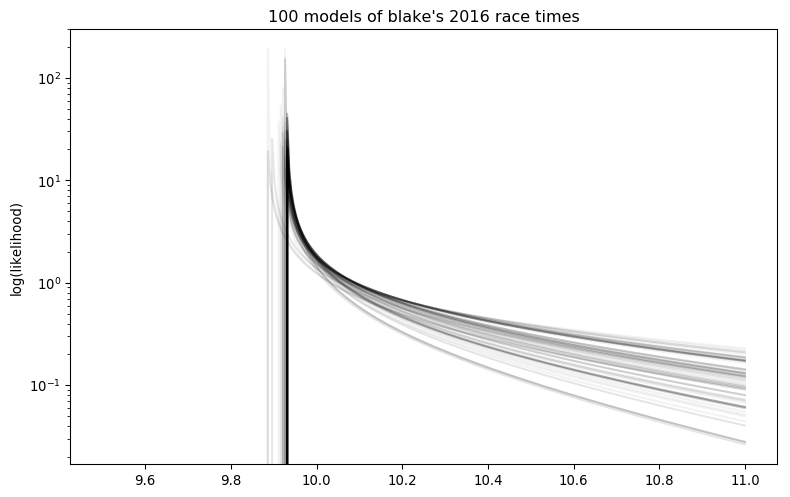

In [22]:
athlete = 0
x = np.linspace(9.5,11,300)
for i,row in enumerate(models[athlete]):
    if i < 100:
        plt.plot( x, spst.gamma.pdf(x, row[0], scale=row[1], loc=row[2]), alpha=0.05, color='k' )
    else:
        break
plt.yticks([])
plt.yscale('log')
plt.ylabel('log(likelihood)')
plt.title("100 models of {}'s 2016 race times".format(names_2016[athlete]))
plt.show()

Charting some of the models in the posterior drives this home. I've looked at a few by tweaking the "player" variable, as well as the output of multiple sample runs, and they all are dominated by Exponential distributions. 

Dang, we've tilted the playing field quite a ways in Rationality Rules' favour. 

Still, let's simulate some races. For each race, I'll pick a random trio of parameters from each model's posterior and feet that into SciPy's [random number routines](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.gamma.html) to generate a race time for each sprinter. Fastest time wins, and we tally up those wins to estimate the odds of any one sprinter coming in first. 

Before running those simulations, though, we should make some predictions. Rationality Rules' view is that (emphasis mine) ...

> \[[9:18](https://youtu.be/02FCYz8bOo8?t=558)\] You see, I absolutely understand why we have and still do categorize sports based upon sex, as it's simply the case that the vast majority of males have significant athletic advantages over females, but strictly speaking it's not due to their sex. It's due to factors that heavily correlate with their sex, such as height, width, heart size, lung size, bone density, muscle mass, muscle fiber type, hemoglobin, and so on. Or, in other words, sports are not segregated due to chromosomes, **they're segregated due to morphology**.

> \[[16:48](https://youtu.be/02FCYz8bOo8?t=1008)\] Which is to say that **the attributes granted from male puberty that play a vital role in explosive events** - such as height, width, limb length, and fast twitch muscle fibers - have not been shown to be sufficiently mitigated by HRT in trans women.

> \[[19:07](https://youtu.be/02FCYz8bOo8?t=1147)\] In some events - such as long-distance running, in which hemoglobin and slow-twitch muscle fibers are vital - I think there's a strong argument to say no, \[*transgender women who transitioned after puberty*\] don't have an unfair advantage, as the primary attributes are sufficiently mitigated. **But in most events, and especially those in which height, width, hip size, limb length, muscle mass, and muscle fiber type are the primary attributes - such as weightlifting, sprinting, hammer throw, javelin, netball, boxing, karate, basketball, rugby, judo, rowing, hockey, and many more** - my answer is yes, most do have an unfair advantage.

... human morphology due to puberty is the primary determinant of race performance. Since our bodies change little after puberty, that implies your race performance should be both constant and consistent. The most extreme version of this argument states that the fastest person should win 100% of the time. I doubt Rationality Rules holds that view, but I am pretty confident he'd place the odds of the fastest person winning quite high.

The opposite view is that the winner is due to chance. Since there are eight athletes competing here, each would have a 12.5% chance of winning. I certainly don't hold that view, but I do argue that chance plays a significant role in who wins. I thus want the odds of the fastest person winning to be somewhere above 12.8%, but not too much higher.

In [23]:
simulations = 15000
wins = [0] * len(all_2016)

print("Simulating {} races, please wait ...".format(simulations), end='')
for sim in range(simulations):
    
    times = list()
    
    for athlete,_ in enumerate(all_2016):

        choice  = int( np.random.rand()*len(models[athlete]) )
        times.append( models[athlete][choice][2] + np.random.gamma( models[athlete][choice][0], models[athlete][choice][1] ) )
        
    wins[ np.argmin(times) ] += 1

print(" done.")
    
by_wins = sorted( np.linspace(0,len(all_2016)-1,len(all_2016),dtype=int), key=lambda x: wins[x], reverse=True)

print()
print("Number of wins during simulation")
print("--------------------------------")
for i,athlete in enumerate(by_wins):
    print( "{:24} {:8} ({:.2f}%)".format(names_2016[athlete], wins[athlete], wins[athlete]*100./simulations) )
sys.stdout.flush()

Simulating 15000 races, please wait ... done.

Number of wins during simulation
--------------------------------
gatlin                       5174 (34.49%)
bolt                         4611 (30.74%)
bromell                      2286 (15.24%)
vicaut                       1491 (9.94%)
simbine                       530 (3.53%)
de grasse                     513 (3.42%)
blake                         278 (1.85%)
meite                         117 (0.78%)


Whew! The fastest 100 metre sprinter of 2016 only had a one in three chance of winning Olympic gold. Of the eight athletes, three had odds better than chance of winning. Even with the field tilted in favor of Rationality Rules, this strongly hints that other factors are more determinative of performance than fixed physiology.

But let's put our Steven Pinker glasses back on for a moment. Yes, the odds of the fastest 100 metre sprinter winning the 2016 Olympics are surprisingly low, but look at the spread between first and last place. What's on my screen tells me that Gatlin is *40-50 times more likely* to win Olympic gold than [Ben Youssef Meite](https://www.iaaf.org/athletes/cote-divoire/ben-youssef-meite-196009), which is a pretty substantial gap. Maybe we can rescue Rationality Rules?

In order for Meite to win, though, he didn't just have to beat Gatlin. He had to also beat *six* other sprinters. If $p_M$ represents the [geometric mean](https://www.math.toronto.edu/mathnet/questionCorner/geomean.html) of Meite beating one sprinter, then his odds of beating seven are ${p_M}^7$. The same rationale applies to Gatlin, of course, but because the geometric mean of him beating seven other racers is higher than $p_M$, repeatedly multiplying it by itself results in a much greater number. With a little math, we can use the number of wins above to estimate how well the first-place finisher would fare against the last-place finisher in a one-on-one race.

In [9]:
win_ratio = float(np.max(wins)) / float(np.min(wins))
prob_head2head = np.power( win_ratio, 1./7. ) / (1 + np.power( win_ratio, 1./7. ))

print("In the above simulation, {} was {:.1f} times more likely to win Olympic gold than {}.".format(
    names_2016[by_wins[0]], win_ratio, names_2016[by_wins[-1]] ))
print("But we estimate that if they were racing head-to-head,", end='')
print(" {} would win only {:.1f}% of the time.".format( names_2016[by_wins[0]], prob_head2head*100. ))

difference = (np.min(all_2016[by_wins[-1]]) - np.min(all_2016[by_wins[0]])) / np.min(all_2016[by_wins[0]])
print(" (For reference, their best race times in 2016 differed by {:.2f}%.)".format( difference * 100. ))

In the above simulation, gatlin was 39.5 times more likely to win Olympic gold than meite.
But we estimate that if they were racing head-to-head, gatlin would win only 62.8% of the time.
 (For reference, their best race times in 2016 differed by 1.53%.)


For comparison, FiveThirtyEight gave roughly those odds for [Hilary Clinton becoming the president of the USA](https://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/) in 2016. That's not all that high, given how "massive" the difference is in their best race times that year.

This is just an estimate, though. Maybe if we pitted our models head-to-head, we'd get different results?

In [10]:
headCount = max( simulations >> 3, 100 )
maxFound = 0

print()
print("Wins when racing head to head ({} simulations each)".format( headCount ))
print("----------------------------------------------")

print("{:10}".format("LOSER->"), end='')
for _,idx in enumerate(min_time):
    print("{:>10}".format(names_2016[idx]), end='')
print()

for x,x_ind in enumerate(min_time):

    print("{:10}".format(names_2016[x_ind]), end='')

    for y in range(len(min_time)):
        if y <= x:
            print("{:10}".format(""), end='')
        else:
            wins = 0
            for rand in range(headCount):

                choice  = int( np.random.rand()*len(models[x_ind]) )
                x_time  = models[x_ind][choice][1] + np.random.gamma( models[x_ind][choice][0], models[x_ind][choice][2] )
                choice  = int( np.random.rand()*len(models[min_time[y]]) )
                y_time  = models[min_time[y]][choice][1] + np.random.gamma( models[min_time[y]][choice][0], models[min_time[y]][choice][2] )

                if y_time < x_time:
                    wins += 1

            temp = wins*100./headCount
            if temp < 50:
                temp = 100 - temp
            if temp > maxFound:
                maxFound = temp
                
            print("{:9.1f}%".format(wins*100./headCount), end='')

    print()
    sys.stdout.flush()

print()
print("The best winning percentage was {:.1f}% (therefore the worst losing percent was {:.1f}%).".format(
    maxFound, 100-maxFound ))


Wins when racing head to head (1875 simulations each)
----------------------------------------------
LOSER->       gatlin      bolt   bromell    vicaut   simbine de grasse     blake     meite
gatlin                   48.9%     52.1%     55.8%     56.4%     59.5%     63.5%     61.9%
bolt                               52.2%     57.9%     55.8%     57.9%     65.8%     60.2%
bromell                                      52.4%     55.3%     55.0%     65.2%     59.0%
vicaut                                                 51.7%     52.2%     59.8%     59.3%
simbine                                                          52.3%     57.7%     57.1%
de grasse                                                                  57.0%     54.7%
blake                                                                                47.2%
meite                                                                                     

The best winning percentage was 65.8% (therefore the worst losing percent was 

Nope, it's pretty much bang on! The columns of this chart represents the loser of the head-to-head, while the rows represent the winner. That number in the upper-right, then, represents the odds of Gatlin coming in first against Meite. When I run the numbers, I usually get a percentage that's less than 5 percentage points off. Since the odds of one person losing is the odds of the other person winning, you can flip around who won and lost by subtracting the odds from 100%. That explains why I only calculated less than half of the match-ups.

I don't know what's on your screen, but I typically get one or two match-ups that are below 50%. I'm again organizing the calculations by each athlete's fastest time in 2016, so if an athlete's win ratio was purely determined by that then every single value in this table would be equal to or above 50%. That's usually the case, thanks to each model favouring the Exponential distribution, but sometimes one sprinter still winds up with a better average time than a second's fastest time. As pointed out earlier, that translates into more wins for the first athlete.

##  Getting Physical

Even at this elite level, you can see the odds of someone winning a head-to-head race are not terribly high. A layperson can create [that much bias in a coin toss](http://www.cmaj.ca/content/181/12/E306.short), yet we still both outcomes of that toss to be equally likely.

This doesn't really contradict Rationality Rules' claim that fractions of a percent in performance matter, though. Each of these athletes differ in physiology, and while that may not have as much effect as we thought it still has *some* effect. What we really need is a way to substract out the effects due to morphology.

If you read [that old blog post](https://freethoughtblogs.com/reprobate/2019/05/30/rationality-rules-is-an-oblivious-transphobe/), you know what's coming next.

> \[[16:48](https://youtu.be/02FCYz8bOo8?t=1008)\] Which is to say that **the attributes granted from male puberty that play a vital role in explosive events - such as height, width, limb length, and fast twitch muscle fibers** - have not been shown to be sufficiently mitigated by HRT in trans women.

According to Rationality Rules, the physical traits that determine track performance are all set in place by puberty. Since puberty finishes roughly around age 15, and human beings can easily live to 75, that implies those traits are fixed for most of our lifespan. In practice that's not quite true, as (for instance) human beings [lose a bit of height in old age](https://health.clevelandclinic.org/can-avoid-losing-height-get-older/), but here we're only dealing with athletes in the prime of their career. Every attribute Rationality Rules lists is effectively constant.

So to truly put RR's claim to the test, we need to fit our model to different parts of the *same* athlete's career, and compare those head-to-head results with the ones where we raced athletes against each other.

In [24]:
table = {"Athlete":[], "First Result":[], "Latest Result":[]}

for name in names_2016:
    
    mask_name = dataset['# Name'] == name
    dates = dataset["Date"][mask_name]
    table['Athlete'].append( name )
    table['First Result'].append( dates.min() )
    table['Latest Result'].append( dates.max() )
    
print( pd.DataFrame(table) )

     Athlete First Result Latest Result
0      blake   2005-07-13    2019-06-21
1       bolt   2007-07-18    2017-08-05
2    bromell   2012-04-06    2019-06-08
3  de grasse   2012-06-08    2019-06-20
4     gatlin   2000-05-13    2019-07-05
5      meite   2003-07-11    2018-06-16
6    simbine   2010-03-13    2019-06-20
7     vicaut   2008-07-05    2019-07-02


That dataset contains official IAAF times going back nearly two decades, in some cases, for those eight athletes. In the case of Bolt and [Meite](https://www.dailysun.co.za/Sport/its-akanis-time-20180804), those span their entire sprinting career.

Which athlete should we focus on? It's tempting to go with Bolt, but he's an outlier who [broke the mathmatical models used to predict sprint times](https://www.wired.com/story/ai-100-meter-dash/). Gatlin would have been my second choice, but between his unusually long career and [history of doping](https://www.bbc.co.uk/sportI/athletics/34060181) there's a decent argument that he too is an outlier. Bromell seems free of any issue, so I'll go with him. Don't agree? I made changing the athlete as simple as altering one variable, so you can pick whoever you like.

I'll divide up these athlete's careers by year, as their performance should be pretty constant over that timespan, and for this sport there's usually enough datapoints within the year to get a decent fit.

In [12]:
athlete = 2   # look at the indicies on the previous table
min_races = 3 # minimum number of races per year; filters out thin data

print()
print("{0} vs. {0}, model building ...".format( names_2016[athlete] ))

mask_ath    = dataset['# Name'] == names_2016[athlete]
min_year    = np.min( dataset['Date'][ mask_ath ] ).year
max_year    = np.max( dataset['Date'][ mask_ath ] ).year

years       = list()
models_ath  = list()
summaries_ath = list()

print("year\tα\tβ\tb")
for year in range(min_year, max_year+1):

    mask_year = (dataset['Date'] > '{}-01-01'.format(year)) & (dataset['Date'] < '{}-01-01'.format(year+1))
    data = dataset['Result'][ mask_ath & mask_year ]
    if len(data) >= min_races:
        years.append( year )
    else:
        continue

    mean = np.mean( data ) - fastest_time      # adjust for the bation offset
    seed = list()
    i = 0
    while i < nwalkers:
        beta = np.random.rand()*1.5 + .5
        b = fastest_time - np.random.rand()*.3

        if lnprob( [mean*beta, beta, b], data ) > -np.inf:
            seed.append( [mean*beta, beta, b] )
            i += 1

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], threads=os.cpu_count())
    sampler.run_mcmc(seed, nsamples)

    samples = sampler.chain[:, -keep:, :].reshape((-1, ndim))
    alpha_mcmc, beta_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
        zip(*np.percentile(samples, [16, 50, 84], axis=0)))

    print("{}".format(year), end='')
    print("\t{:.3f} (+{:.3f} -{:.3f})".format(*alpha_mcmc), end='')
    print("\t{:.3f} (+{:.3f} -{:.3f})".format(*beta_mcmc), end='')
    print("\t{:.3f} (+{:.3f} -{:.3f})".format(*b_mcmc))
    sys.stdout.flush()

    models_ath.append( samples )
    summaries_ath.append( [*alpha_mcmc, *beta_mcmc, *b_mcmc] )

print("... done.")

print()
print("{0} vs. {0}, head to head ({1} simulations)".format( names_2016[athlete], headCount ))
print("----------------------------------------------")

print("{:7}".format("LOSER->"), end='')
for year in years:
    print("{:>7}".format(year), end='')
print()

maxFound = 0
for x_ind,x in enumerate( years ):

    print("{:7}".format(x), end='')

    for y_ind,y in enumerate( years ):
        if y <= x:
            print("{:7}".format(""), end='')
        else:
            wins = 0
            for rand in range(headCount):

                choice  = int( np.random.rand()*len(models_ath[x_ind]) )
                x_time  = models_ath[x_ind][choice][2] + np.random.gamma( models_ath[x_ind][choice][0], models_ath[x_ind][choice][1] )
                choice  = int( np.random.rand()*len(models_ath[y_ind]) )
                y_time  = models_ath[y_ind][choice][2] + np.random.gamma( models_ath[y_ind][choice][0], models_ath[y_ind][choice][1] )

                if y_time < x_time:
                    wins += 1
                    
            temp = wins*100./headCount
            if temp < 50:
                temp = 100 - temp
            if temp > maxFound:
                maxFound = temp
                
            print("{:6.1f}%".format(wins*100./headCount), end='')

    print()
    sys.stdout.flush()

print()
print("The best winning percentage was {:.1f}% (therefore the worst losing percent was {:.1f}%).".format(
    maxFound, 100-maxFound ))


bromell vs. bromell, model building ...
year	α	β	b
2012	0.639 (+0.317 -0.219)	0.817 (+0.406 -0.280)	10.370 (+0.028 -0.415)
2013	0.662 (+0.157 -0.118)	1.090 (+0.258 -0.195)	9.970 (+0.018 -0.070)
2014	0.457 (+0.118 -0.070)	1.556 (+0.403 -0.238)	9.762 (+0.007 -0.035)
2015	0.312 (+0.069 -0.064)	2.082 (+0.459 -0.423)	9.758 (+0.002 -0.016)
2016	0.356 (+0.092 -0.104)	1.761 (+0.457 -0.513)	9.835 (+0.005 -0.037)
... done.

bromell vs. bromell, head to head (1875 simulations)
----------------------------------------------
LOSER->   2012   2013   2014   2015   2016
   2012         61.3%  67.4%  74.3%  71.0%
   2013                65.1%  70.7%  66.9%
   2014                       57.7%  48.7%
   2015                              40.2%
   2016                                   

The best winning percentage was 74.3% (therefore the worst losing percent was 25.7%).


Again, I have no idea what you're seeing, but I've looked at a number of Bromell vs. Bromell runs, and every one I've done shows at least as much variation, if not more, than runs that pit Bromell against other athletes. Bromell vs. Bromell shows even more variation in success than the coin flip benchmark, giving us justification for saying Bromell has a significant advantage over Bromell.

I've also changed that variable myself, and seen the same pattern in other athletes. Worried about a lack of datapoints causing the model to "fuzz out" and cover a wide range of values? I thought of that and restricted the code to filter out years with less than three races. Honestly, I think it puts my conclusion on firmer ground.

## Conclusion

> **[Texas Sharpshooter Fallacy](https://www.logicallyfallacious.com/tools/lp/Bo/LogicalFallacies/175/Texas-Sharpshooter-Fallacy)**:  Ignoring the difference while focusing on the similarities, thus coming to an inaccurate conclusion.  Similar to the gambler’s fallacy, this is an example of inserting meaning into randomness.

Rationality Rules loves to point to sporting records and the outcome of single races, as on the surface these seem to justify his assertion that differences in performance of fractions of a percent matter. In reality, he's painting a bullseye around a very small subset of the data and ignoring the rest. When you include *all* the data, you find Rationality Rules has badly missed the mark. Physiology cannot be as determinative as Rationality Rules claims, other factors must be important enough to sometimes overrule it.

And, at long last, I can call bullshit on this (emphasis mine):

> \[[17:50](https://youtu.be/02FCYz8bOo8?t=1070)\] It's important to stress, by the way, that these are just my views. I'm not a biologist, physiologist, or **statistician, though I have had people check this video who are.**

Either Rationality Rules found a statistician who has no idea of variance, which is like finding a computer scientist who doesn't know [boolean logic](https://www.i-programmer.info/babbages-bag/235-logic-logic-everything-is-logic.html), or he never actually consulted a statistician. Chalk up [yet](https://freethoughtblogs.com/reprobate/2019/06/28/rationality-rules-is-a-lying-transphobe/) [another](https://freethoughtblogs.com/reprobate/2019/07/04/lies-of-omission/) [lie](https://freethoughtblogs.com/reprobate/2019/07/25/cherry-picking/) in his column.